In [1]:
import sys
import sklearn

assert sys.version_info >= (3, 5)

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(17)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

784
5


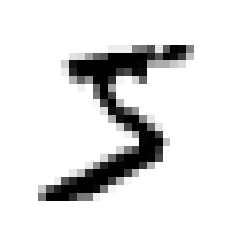

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
# Each image is 28 * 28 pixels
print(X[0].size)
print(y[0])

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
y = y.astype(np.uint8)
print(y[0])

TRAIN_SET_NUM = 60000
X_train, X_test, y_train, y_test = (
    X[:TRAIN_SET_NUM],
    X[TRAIN_SET_NUM:],
    y[:TRAIN_SET_NUM],
    y[TRAIN_SET_NUM:],
)


5


In [5]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=17)
sgd_clf.fit(X_train, y_train_5)

ret = sgd_clf.predict([some_digit])
assert ret == [[True]]


# Performance Evaluation

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
for train_index, test_index in skfolds.split(X_train, y_train_5):
	clone_clf = clone(sgd_clf)
	X_train_folds = X_train[train_index]
	y_train_folds = y_train_5[train_index]
	X_test_fold = X_train[test_index]
	y_test_fold = y_train_5[test_index]

	clone_clf.fit(X_train_folds, y_train_folds)
	y_pred = clone_clf.predict(X_test_fold)
	n_correct = sum(y_pred == y_test_fold)
	print(n_correct / len(y_pred))

0.92
0.9648
0.9658


In [7]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96675, 0.9618 , 0.94425])

In [8]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [9]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_train_5, y_train_pred)
print(conf_mat)

[[53936   643]
 [ 1901  3520]]


In [10]:
from sklearn.metrics import precision_score, recall_score

prec_score = precision_score(y_train_5, y_train_pred)
print(prec_score)
reca_score = recall_score(y_train_5, y_train_pred)
print(reca_score)

from sklearn.metrics import f1_score
f1_score = f1_score(y_train_5, y_train_pred)
print(f"f1 score: {f1_score}")

0.8455440787893346
0.6493266924921601
f1 score: 0.7345575959933222


In [11]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


In [12]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)  # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)  # Not shown
    plt.grid(True)  # Not shown
    plt.axis([-50000, 50000, 0, 1])  # Not shown


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# plt.figure(figsize=(8, 4))  # Not shown
# plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.plot(
#     [threshold_90_precision, threshold_90_precision], [0.0, 0.9], "r:"
# )  # Not shown
# plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")  # Not shown
# plt.plot(
#     [-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:"
# )  # Not shown
# plt.plot([threshold_90_precision], [0.9], "ro")  # Not shown
# plt.plot(
#     [threshold_90_precision], [recall_90_precision], "ro"
# )  # Not shown                                           # Not shown
# plt.show()


In [13]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)


# plt.figure(figsize=(8, 6))
# plot_precision_vs_recall(precisions, recalls)
# plt.plot([recall_90_precision, recall_90_precision], [0.0, 0.9], "r:")
# plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
# plt.plot([recall_90_precision], [0.9], "ro")

# plt.show()


In [18]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

y_train_pred_90 = y_scores >= threshold_90_precision

ret = precision_score(y_train_5, y_train_pred_90)
print(f"Precision: {ret}")

ret = recall_score(y_train_5, y_train_pred_90)
print(f"Recall: {ret}")

1854.5025990559493
Precision: 0.9001214329083181
Recall: 0.5469470577384247


In [21]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=17)
svm_clf.fit(X_train[:1000], y_train[:1000])
ret = svm_clf.predict([some_digit])
print(ret)

some_digit_score = svm_clf.decision_function([some_digit])
print(some_digit_score)

[5]
[[ 2.81585438  7.09167958  3.82972099  0.79365551  5.8885703   9.29718395
   1.79862509  8.10392157 -0.228207    4.83753243]]


In [22]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=17))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ret = ovr_clf.predict([some_digit])
print(ret)

[5]


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


array([[5591,    0,   23,    5,    8,   46,   34,    5,  210,    1],
       [   1, 6406,   39,   24,    4,   45,    4,    8,  198,   13],
       [  28,   26, 5256,   97,   73,   28,   64,   37,  339,   10],
       [  23,   17,  120, 5252,    2,  211,   26,   38,  371,   71],
       [  12,   14,   47,   12, 5220,   12,   35,   24,  298,  168],
       [  26,   16,   34,  169,   53, 4491,   75,   14,  482,   61],
       [  29,   16,   46,    3,   43,   99, 5555,    4,  122,    1],
       [  19,    9,   53,   26,   53,   15,    3, 5705,  170,  212],
       [  18,   64,   47,   86,    3,  129,   24,   11, 5424,   45],
       [  24,   18,   30,   65,  121,   38,    1,  176,  332, 5144]])

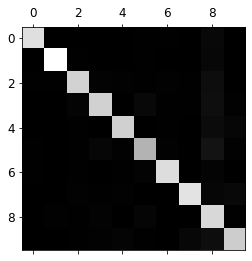

In [26]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


[[0.         0.         0.00388317 0.00084417 0.00135067 0.00776633
  0.00574033 0.00084417 0.03545501 0.00016883]
 [0.00014832 0.         0.00578463 0.00355977 0.0005933  0.00667458
  0.0005933  0.00118659 0.02936814 0.00192821]
 [0.00469956 0.00436388 0.         0.01628063 0.01225243 0.00469956
  0.01074186 0.00621014 0.05689829 0.00167842]
 [0.00375143 0.00277279 0.01957266 0.         0.00032621 0.03441527
  0.00424074 0.00619801 0.06051215 0.01158049]
 [0.00205409 0.00239644 0.00804519 0.00205409 0.         0.00205409
  0.0059911  0.00410818 0.05100993 0.02875727]
 [0.00479616 0.00295148 0.00627191 0.03117506 0.00977679 0.
  0.01383509 0.00258255 0.08891348 0.01125254]
 [0.0049003  0.00270362 0.0077729  0.00050693 0.00726597 0.01672862
  0.         0.0006759  0.02061507 0.00016898]
 [0.00303272 0.00143655 0.0084597  0.00415004 0.0084597  0.00239425
  0.00047885 0.         0.02713488 0.03383879]
 [0.0030764  0.0109383  0.00803281 0.01469834 0.00051273 0.02204751
  0.00410186 0.00188

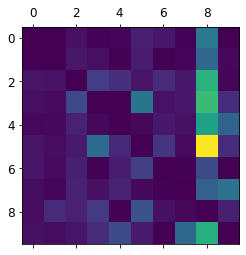

In [31]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
print(norm_conf_mx)
plt.matshow(norm_conf_mx, 0)
plt.show()

# Multi-Label Classification

In [38]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
ret = knn_clf.predict([some_digit])
print(f"Some digit (5) is large: {ret[0][0]}, is odd: {ret[0][1]}")


Some digit (5) is large: False, is odd: True


# Multi-Output Classification

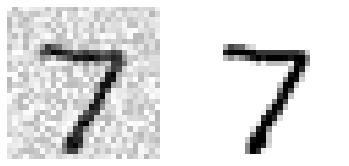

In [41]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")


some_index = 0
plt.subplot(121)
plot_digit(X_test_mod[some_index])
plt.subplot(122)
plot_digit(y_test_mod[some_index])
plt.show()


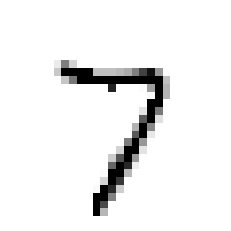

In [43]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)